In [7]:
import requests
import json
import prettytable
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = r"C:\Users\nsbea\OneDrive\4_coding\price\data"
os.chdir(data_path)

# 1. Read dataset

In [3]:
# define parameters
target = ['WPUFD4',
          'WPUID54',
          'WPUID53',
          'WPUID52',
          'WPUID51'
          ]

map_stage = {'WPUID51':'Stage 1',
             'WPUID52':'Stage 2',
             'WPUID53':'Stage 3',
             'WPUID54':'Stage 4',
             'WPUFD4':'Final demand (excluding exports)'
             }

start = '2015'
end = '2022'

In [4]:
# ref https://www.bls.gov/developers/api_python.htm#python2
def get_data_us(target,start,end):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid":target,"startyear":start, "endyear":end})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    
    json_data = json.loads(p.text)
    for series in json_data['Results']['series']:
        x=prettytable.PrettyTable(["series id","year","period","value","footnotes"])
        seriesId = series['seriesID']
        for item in series['data']:
            year = item['year']
            period = item['period']
            value = item['value']
            footnotes=""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','
            if 'M01' <= period <= 'M12':
                x.add_row([seriesId,year,period,value,footnotes[0:-1]])
        output = open(seriesId + '.csv','w')
        output.write (x.get_string().replace('|',','))
        output.close()

def read_df(target):
    output = []
    # get dataframe from each csv
    target_csv = [x + '.csv' for x in target]
    
    for f in target_csv:
        df = pd.read_csv(f, header=1, skipfooter=1, engine='python')
        # remove whitespace
        df.columns = df.columns.str.strip()
        df['series id'] = df['series id'].str.strip()
        # rename the ID
        df.rename(columns = {'series id':'stage'}, inplace = True)
        df = df.drop(df.index[0])
        # change type of each columns
        df['year'] = df['year'].astype(int)
        df['period'] = df['period'].str.strip().str[1:].astype(int)
        df['date'] = pd.to_datetime(['{}-{}-01'.format(y,m) for y, m in zip(df.year, df.period)])
        df = df[['date','stage','value']]
        df['country'] = 'US'
        df['stage'] = df['stage'].map(map_stage)
        output.append(df) 
    return output

def get_data_jp(im=True):
    # japanese data
    url = r'https://www.boj.or.jp/statistics/pi/fdid/fdid.xlsx'
    
    df = pd.read_excel(url)
    
    col = list(df.columns)
    # delete columns which not be used, and rename
    del col[0:2]
    del col[1]
    df = df[col]
    df.rename(columns = {'Unnamed: 2':'stage', 'Unnamed: 4':'name'}, inplace = True)
    
    if im == True:
        df_jp = df[df['name']=='All commodities'].set_index('stage').drop('name',axis=1).T
    else:
        df_jp = df[df['name'] == 'All commodities, less imports'].set_index('stage').drop('name',axis=1).T
        
    idx = [str(x) for x in list(df_jp.index)]
    year, month = [x[0:4] for x in idx], [x[4:] for x in idx]
    df_jp['year'], df_jp['month'] = year, month
    df_jp['date'] = pd.to_datetime(['{}-{}-01'.format(y,m) for y, m in zip(df_jp.year, df_jp.month)])
    df_jp = df_jp.drop(['year','month'],axis=1)
    df_jp = pd.melt(df_jp, id_vars='date',value_vars=['Stage 1','Stage 2','Stage 3','Stage 4','Final demand (excluding exports)','Final demand (including exports)'])
    df_jp['country'] = 'JP'
    return df_jp


In [10]:
# work flow
get_data_us(target,start,end)
df_list = read_df(target)
df_us = pd.concat(df_list).reset_index(drop=True)
df_jp = get_data_jp(im=False)

# conbine the dataframe
df = pd.concat([df_us,df_jp]).reset_index(drop=True)

# 2. Plot

In [11]:
def plot_twoline(df_us, df_jp):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20,8))
    
    sns.lineplot(data=df_us, x='date',y='value', hue='stage', markers=True,ax=ax1).set(title='USA')
    sns.lineplot(data=df_jp, x='date',y='value', hue='stage', markers=True,ax=ax2).set(title='JAPAN')
    
    plt.show()

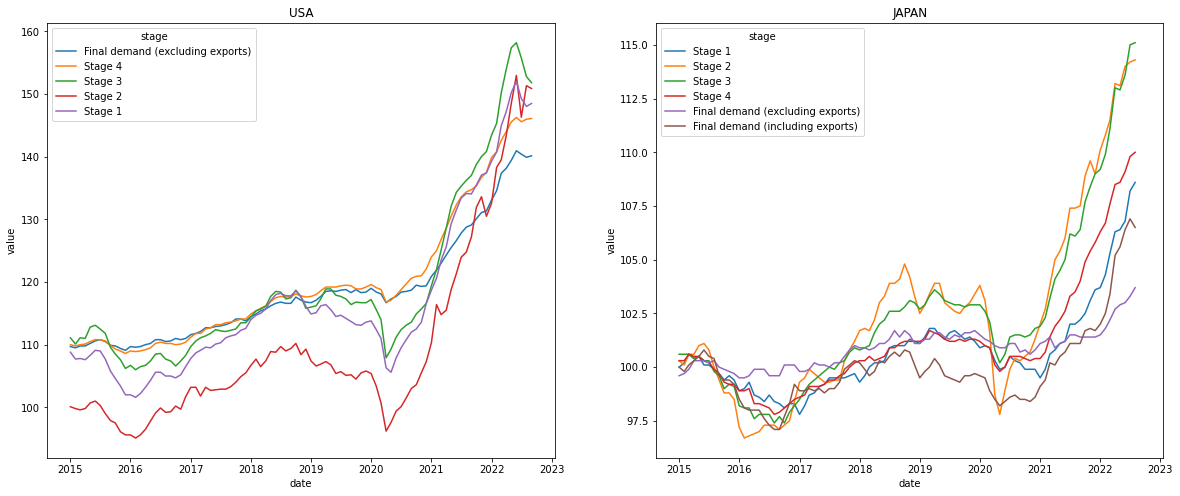

In [12]:
plot_twoline(df_us, df_jp)

# TO DO

- 凡例を合わせる
- 輸出含む除くのパラメータを作成する
- 前年比、前期比、四半期平均などの機能追加